# Solving Complex Captcha Using CNN

## 1. Introduction

**What does CAPTCHA mean?**

>CAPTCHA stands for Completely Automated Public Turing test to tell Computers and Humans Apart. In other words, CAPTCHA determines whether the user is real or a spam robot. CAPTCHAs stretch or manipulate letters and numbers, and rely on human ability to determine which symbols they are.

## 2. Objective

>Given a captcha image our model should be able to detect captcha text correctly

## 3. Prepare Problem
1. Load libraries
2. Load dataset

### 3.1 Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import cv2
import math
import glob
import keras
import random
import collections
import numpy as np
import pandas as pd
from datetime import datetime
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import Sequence
from scipy.misc import imread
from keras import backend as K
from tensorflow.python.client import device_lib
# from IPython.display import clear_output

import matplotlib
matplotlib.use("Agg")
%matplotlib inline

Using TensorFlow backend.


### 3.2 Load Dataset

* All captcha images are stored in a folder names set4
* Name of each image file is its `{captcha_value}.jpg`

In [6]:
## utility func to create data frame of captcha image names and corresponding labels
def load_data(img_path):
    print("Loading Captcha Images.")
    captchas = []
    for x in tqdm(os.listdir(img_path)):
        if x != '.DS_Store':
            label = x.split(".")[0]
            captchas.append(label)
    
    df = pd.DataFrame(captchas, columns=['label']) 
    df['image_path'] = df['label'].apply(lambda x: x + '.jpg')
    return df.head(40000)

def get_devices():
    print(K.tensorflow_backend._get_available_gpus())
    print('*'*100)
    print(device_lib.list_local_devices())
    
    
def plot_image(img):
    plt.axis("off")
    plt.imshow(img)
    plt.show()


In [7]:
## check if your device has GPU support or not
get_devices()

['/job:localhost/replica:0/task:0/device:GPU:0']
****************************************************************************************************
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2325678234084590586
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 355467264
locality {
  bus_id: 1
}
incarnation: 1084925212961095497
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [8]:
img_path = 'set4/'

df = load_data(img_path)

  0%|          | 0/214709 [00:00<?, ?it/s]

Loading Captcha Images.


100%|██████████| 214709/214709 [00:00<00:00, 1041921.71it/s]


### 4. Summarize the Dataset
#### 4.a) Descriptive statistics
1. Dimensions of the dataset.
2. Peek at the data itself.
3. Statistical summary of all attributes.
4. Breakdown of the data by the class variable.

#### 4.b) Data visualizations

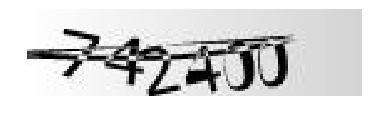

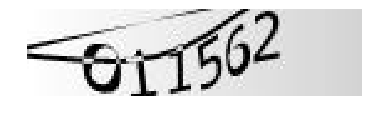

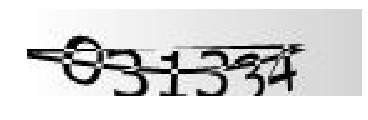

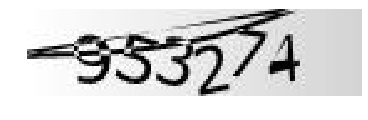

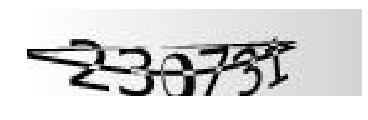

In [17]:
images = df['image_path'].values[:5]

for image in images:
    img = np.array(Image.open('set4/{}'.format(image)))
    plot_image(img)

#### 4.a.1) Dimensions of dataset

In [18]:
# 1. Dimensions of dataset
print(df.shape)

(40000, 2)


#### 4.a.2) Peek at the data

In [19]:
# 2. Peek at the data
df.head(5)

,label,image_path
0,742400,742400.jpg
1,011562,011562.jpg
2,031334,031334.jpg
3,953274,953274.jpg
4,230731,230731.jpg


#### 4.a.3) Statistical Summary

In [20]:
# 3. Statistical summary of all attributes.
df.describe()

,label,image_path
count,40000,40000
unique,40000,40000
top,617730,361603.jpg
freq,1,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
label         40000 non-null object
image_path    40000 non-null object
dtypes: object(2)
memory usage: 625.1+ KB


#### Observations:
* Shape of our dataset is (214709, 2)
* Dataset do not contain any null values

### 5.1 Split-out  dataset

In [22]:
y = df['label']
X = df.drop(['label'], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42 )

In [24]:
X_train['label'] = y_train
X_test['label'] = y_test

In [25]:
X_train.head(2)

,image_path,label
38015,425068.jpg,425068
2281,207387.jpg,207387


#### saving train and test dataframes

In [26]:
X_train.to_csv('train_df.csv')
X_test.to_csv('test_df.csv')

In [27]:
IMAGE_DIMS = (100, 100, 3)
BATCH_SIZE = 50
EPOCHS = 25
steps_per_epoch = int(np.ceil(X_train.shape[0]/BATCH_SIZE))

In [28]:
# variables to encode labels
train_list = [a for a in "0123456789"]
len_train_list = len(train_list)
train_dict = dict(zip(range(0, len(train_list)), train_list))
train_dict.update({v: k for k, v in train_dict.items()})
temp_list = [0 for i in range(0, len(train_list) * 6)]

#### Creating Sequence Generator

In [29]:
# utility func to create a sequence generator for batch processing data

class DataSequence(Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """
    def __init__(self, df, batch_size, mode='train'):
        self.df = df # your pandas dataframe
        self.bsz = batch_size # batch size
        self.mode = mode # shuffle when in train mode

        # Take labels and a list of image locations in memory
        self.labels = self.df['label'].values
        self.im_list = self.df['image_path'].tolist()

    def __len__(self):
        # compute number of batches to yield
        return int(math.ceil(len(self.df) / float(self.bsz)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch if in training mode
        self.indexes = range(len(self.im_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        labels = []
        temp_labels = self.labels[idx * self.bsz: (idx + 1) * self.bsz]
        for lab in temp_labels:
            label = list(temp_list)
            for index, l in enumerate(lab):
                label[train_dict[l] + (index * len_train_list)] = 1
            labels.append(label)
        return np.array(labels)

    def get_batch_features(self, idx):
        # Fetch a batch of inputs
        batch_images = [] 
        for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]:
            image = imread('set4/' + im)
            image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
            image = img_to_array(image)
            batch_images.append(image / 255.0)
        return np.array(batch_images)
        

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

### Trying Various CNN Models with different layers and layer attributes

### `Model1: 5 CNN Layers + 3*3 kernel + BN + MaxPooling + Dropout + relu `

In [30]:
# func to create model1

def model1():
    # create model
    model = keras.Sequential()
    # 1_conv
    model.add(keras.layers.Conv2D(32, (3, 3), padding="same",
                                      input_shape=IMAGE_DIMS))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
    # 2_conv
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.Conv2D(64, (3, 3), padding="same"))
    # 3_conv
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(128, (3, 3), padding="same"))
    # 4_conv
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.Conv2D(128, (3, 3), padding="same"))
    # 5_conv
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.BatchNormalization(axis=-1))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Flatten())
    # 1 dim

    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(60))
    model.add(keras.layers.Activation("sigmoid"))
    return model

In [31]:
# compiling model with optimizer, loss and matrics

model1 = model1()

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train Model

In [33]:
def train_model(model):
    sequence = DataSequence(X_train, BATCH_SIZE)
    with tf.device(':/gpu'):
        model.fit_generator(sequence, verbose=1, epochs=EPOCHS, steps_per_epoch=steps_per_epoch ,use_multiprocessing=True)

In [34]:
train_model(model1)

Epoch 1/25
560/560 [==============================] - 304s 543ms/step - loss: 0.3101 - acc: 0.8764
Epoch 2/25
560/560 [==============================] - 64s 115ms/step - loss: 0.1209 - acc: 0.9546
Epoch 3/25
560/560 [==============================] - 64s 114ms/step - loss: 0.0628 - acc: 0.9790
Epoch 4/25
560/560 [==============================] - 67s 119ms/step - loss: 0.0432 - acc: 0.9863
Epoch 5/25
560/560 [==============================] - 63s 113ms/step - loss: 0.0341 - acc: 0.9896
Epoch 6/25
560/560 [==============================] - 66s 119ms/step - loss: 0.0291 - acc: 0.9911
Epoch 7/25
560/560 [==============================] - 66s 119ms/step - loss: 0.0255 - acc: 0.9922
Epoch 8/25
560/560 [==============================] - 66s 117ms/step - loss: 0.0225 - acc: 0.9931
Epoch 9/25
560/560 [==============================] - 64s 114ms/step - loss: 0.0206 - acc: 0.9936
Epoch 10/25
560/560 [==============================] - 65s 117ms/step - loss: 0.0196 - acc: 0.9938
Epoch 11/25
560/56

### Saving Model

In [36]:
# util func to save model to disc 
    
def save_model_to_disc(model, name): 
    # save model
    print("Saving Model.")
    path = os.getcwd()
    print ("The current working directory is %s" % path)
    # Create models Directory if don't exist
    if not os.path.exists(path + '/' + 'models'):
        os.mkdir(path + '/' + 'models')
        
    model_json = model.to_json()
    with open("models/{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
        model.save_weights("models/{}.h5".format(name))
        model.save_weights("models/{}.h5".format(name))
        print("Saved model {} to disk.".format(name))

In [37]:
save_model_to_disc(model1, 'tm')

Saving Model.
The current working directory is /home/rohit-singh/trademark_captcha
Saved model tm to disk.


### Load Model

In [38]:
def load_model(model_name):
    # load model
    json_file = open('models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights("models/{}.h5".format(model_name))
    print("Loaded model from disk")
    return model

In [40]:
def getTestImages():
    test_images = []
    test_labels = []
    actual_test_labels = []
    for path in tqdm(X_test['image_path'].values[:500]):
        
        label = list(temp_list)
        for index, l in enumerate(path.split(".jpg")[0]):
            label[train_dict[l] + (index * 10)] = 1
        test_labels.append(label)
        actual_test_labels.append(path.split(".jpg")[0])
        
        image = np.array(Image.open('set4/{}'.format(path)))
        image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
        image = img_to_array(image)
        test_images.append(image / 255.0)
    return np.array(test_images), test_labels, actual_test_labels

In [41]:
test_images, test_labels, actual_test_labels = getTestImages()

100%|██████████| 500/500 [00:06<00:00, 75.94it/s]


In [42]:
model = load_model('tm')

Loaded model from disk


In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

500/500 [==============================] - 1s 1ms/step
Test accuracy: 0.9850666799545288
Test loss: 0.1377260706424713


In [44]:
def predict_label(prediction):
    predictions = []
    for i in range(len(prediction)):
        locs = [[np.argmax(prediction[i][x:x + len_train_list]), x + np.argmax(prediction[i][x:x + len_train_list])]
                for x in range(0, 60, len_train_list)]
        predictions.append("".join(list_to_label(locs)))
    return predictions


def list_to_label(list):
    return [train_dict[x[0]] for x in list]


def getTestImage(path):
    image = np.array(Image.open('{}'.format(path)))
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    plot_image(image)
    image = img_to_array(image)
    return np.array([image / 255.0])

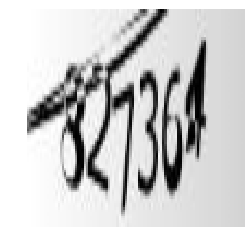

['827364']

In [45]:
img = getTestImage('abc.jpg')

pred = model.predict(img)
predictions = predict_label(pred)
predictions